# Introduction to SoccerTrack

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=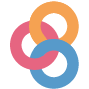)](https://)

---

This quick tutorial introduces the key concepts and basic features of GeoPandas to help you get started with your projects.

## Concepts

### Multiple Object Tracking in SoccerTrack

In a broad definition, Multiple Object Tracking (MOT) is the problem of automatically identifying multiple objects in a video and representing them as a set of trajectories. 

The typical approach to MOT algorithms follows the tracking-by-detection paradigm, which attempts to solve the problem in two steps. 

1. The detection model detects items of interest via bounding boxes in each frame, then 
2. the association model extracts visual re-identification (reID) features corresponding to each bounding box, ties the detection to an existing track, or generates a new track based on specified metrics set on features.

One large challenge in the tracking-by-detection paradigm is scalability. The detection model is typically a deep learning model, which is computationally expensive. The association model is also computationally expensive, as it requires reID features to be extracted for each bounding box. Recent approaches, such as [TrackFormer](https://arxiv.org/abs/2101.02702)/[TransTrack](https://arxiv.org/abs/2012.15460), have attempted to address this challenge by using a single deep learning model to perform both detection and association. However, there is no clear consensus on the best approach to MOT as tracking-by-detection models are still competitive ([ByteTrack](https://arxiv.org/abs/2110.06864)/[BoT-SORT](https://arxiv.org/abs/2206.14651)/[Strong-SORT](https://arxiv.org/abs/2202.13514)).

> **Note:** IMHO, approaches that adhere to ["The Bitter Lesson"](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) are the most promising. [Unicorn: Towards Grand Unification of Object Tracking](https://arxiv.org/abs/2207.07078) demonstrates that a single network can solve four tracking problems (SOT, MOT, VOS, MOTS) simultaneously. I think this is a direction many will follow.

In SoccerTrack, we implement the tracking-by-detection paradigm. 

### SoccerTrack DataFrame

SoccerTrack extends the popular data science library [pandas](https://pandas.pydata.org/) by adding an interface to handle tracking data. If you are not familiar with [pandas](https://pandas.pydata.org/), we recommend taking a quick look at its [Getting started](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) documentation before proceeding.

There are two core data structures in SoccerTrack, the BoundingBoxDataFrame and the CoordinateDataFrame. Both are,

   1. Subclasses of pandas.DataFrame and inherit all of its functionality
   2. Inherited from the SoccerTrackMixin and are designed to work with the SoccerTrack API

The main difference is that the CoordinateDataFrame has comes built-in with that handles the coordinates, while the BoundingBoxDataFrame is made to be compatibile with bounding box data.

![](./assets/dataframe_inheritance.png)

## Reading and writing files

## Simple accessors and methods

## Tracking

## Visualization


## What next?